# Прогнозирование оттока клиентов телеком компании
## Исследовательский анализ данных
### Описание данных

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта:**
Построить модель, которая будет предсказывать планирует ли клиент уходить. При этом метриика `auc-roc` должна быть выше 0,85.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Обзор данных

In [67]:
# загрузка необходимых библиотек

# импорты из стандартной библиотеки
import os
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik

# импорты модулей текущего проекта
from types import SimpleNamespace
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    make_scorer,
    roc_curve,
    confusion_matrix,
    plot_confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split, 
    KFold, 
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline

# настройки
warnings.filterwarnings("ignore")

In [4]:
# константа
RANDOM_STATE = 270223

In [5]:
# загрузка данных
pth_prod = 'data_final_provider'
pth_dev = '/datasets/final_provider/'

df_folder = pth_dev if os.path.exists(pth_dev) else pth_prod

df = SimpleNamespace()
for file_name in os.listdir(df_folder):
    if os.path.isfile(os.path.join(df_folder, file_name)):
        setattr(
            df, 
            file_name.split(".")[0],
            pd.read_csv(os.path.join(df_folder, file_name))
        )    

In [6]:
# функция для открытия данных
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    
get_data_info(df.contract)   

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1629,3533-UVMOM,2014-06-01,No,Two year,No,Bank transfer (automatic),70.95,4741.45
5888,8610-WFCJF,2015-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,95.60,4783.5
4408,2824-DXNKN,2014-02-01,No,Two year,Yes,Bank transfer (automatic),71.45,5025.85
6157,6776-TLWOI,2019-07-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,19.85,64.55
2730,1169-SAOCL,2016-01-01,No,One year,Yes,Bank transfer (automatic),106.65,5168.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,2669-QVCRG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Первые выводы по данным: **Файл Contract**

1) Пропусков в данных нет

2) Необходимо будет поменять типы данных

   - `BeginDate`, `EndDate`	- на дату. Или в случае второго столбца, то изменить на ушёл ли клиент или ещё пользуется услугами. Тем самым сделать целевым признаком.
   
   - `TotalCharges` на тип Float
   
Информация по столбцам:   
* `customerID` - индивидуальный номер пользователя (есть во всех таблицах)
* `BeginDate`- дата начала пользования услугами
* `EndDate` - дата окончания пользования услугами
* `Type` - тип оплаты: ежемесячный, годовой и тд.
* `PaperlessBilling` - электронный платёжный документ
* `PaymentMethod` - способ оплаты
* `MonthlyCharges` - ежемесячные траты на услуги
* `TotalCharges` - всего потрачено денег на услуги

In [7]:
get_data_info(df.personal)  

,customerID,gender,SeniorCitizen,Partner,Dependents
2394,8231-BSWXX,Male,0,No,No
1754,3658-QQJYD,Male,0,No,No
6231,3296-SILRA,Female,1,Yes,No
6329,6603-QWSPR,Female,0,No,No
4831,4654-GGUII,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,2669-QVCRG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Первые выводы по данным: **Файл personal**

1) Пропусков в данных нет, и данных столько же, сколько в предыдущем файле

2) Тип данных менять не нужно


Информация по столбцам:   
* `customerID` - индивидуальный номер пользователя (есть во всех таблицах)
* `gender` - пол
* `SeniorCitizen` - наличие пенсионного статуса по возрасту
* `Partner` - наличие супруга или супруги
* `Dependents` - наличие иждевенцев

In [8]:
get_data_info(df.internet) 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1137,7767-UXAGJ,DSL,No,No,No,No,No,No
348,2181-UAESM,DSL,Yes,No,Yes,No,No,No
2305,6313-GIDIT,DSL,No,Yes,Yes,No,Yes,Yes
1581,9430-FRQOC,Fiber optic,No,No,Yes,Yes,No,No
4529,8066-POXGX,DSL,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5419-JKZNQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [9]:
get_data_info(df.phone) 

,customerID,MultipleLines
2034,8182-BJDSI,Yes
4549,9367-TCUYN,No
2063,4957-TIALW,No
5302,2971-SGAFL,Yes
3752,3005-TYFRD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2669-QVCRG,No
freq,1,3390


Первые выводы по данным: **Файлов internet и phone** 

1) Пропусков в данных нет, однако данных меньше, чем в предыдущих таблицах. А это означает, что есть пользователи, которые не пользуются услугами интернетаи и телефона, и есть также пользователи, которые используют и то, и другое.

2) Тип данных менять не нужно

Информация по столбцам:   
* `customerID` - индивидуальный номер пользователя (есть во всех таблицах)
* `InternetService` - вид типа подключения: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*)
* `OnlineSecurity` - наличие услуги "блокировка небезопасных сайтов"
* `OnlineBackup`наличие услуги "Облачное хранилище файлов для резервного копирования данных"
* `DeviceProtection` - наличие услуги "антивирус"
* `TechSupport` - наличие услуги "выделенной линии технической поддержки"
* `StreamingTV` - наличие услуги "Стриминговое телевидение"
* `StreamingMovies` - наличие услуги "каталог фильмов для стримингово телевидения"
* `MultipleLines` - наличие возможности ведения параллельных линий во время звонка


А также стоит отметить, что среди `customerID` во всех таблицах дубликатов нет. Это означает, что дубликаты устранять не нужно.

In [10]:
all_count = df.contract['customerID'].count()
print('Общее количество пользователей в исследовании {} или 100%'.format(all_count))
print('Количество пользователей, которые пользуются интернетом {0} или {1}%'.format(
    df.internet['customerID'].count(), 
    round(df.internet['customerID'].count()/all_count*100)))
print('Количество пользователей, которые пользуются услугами телефонии {0} или {1}%'.format(
    df.phone['customerID'].count(), 
    round(df.phone['customerID'].count()/all_count*100)))
print('Количество пользователей, которые используют обе услуги {} или {}%'.format(
    df.phone['customerID'].count() + df.internet['customerID'].count() - all_count, 
    round((df.phone['customerID'].count() + df.internet['customerID'].count() - all_count)/all_count*100)))

Общее количество пользователей в исследовании 7043 или 100%
Количество пользователей, которые пользуются интернетом 5517 или 78%
Количество пользователей, которые пользуются услугами телефонии 6361 или 90%
Количество пользователей, которые используют обе услуги 4835 или 69%


Изменим **типы данных**, где это было необходимо. А также изменим типы `int64` и `float64` на более меньшие разрядности для более быстрой работы кода. Однако, перед этим ещё добавим в первую таблицу дополнительный столбец `client_leave`, где 1 - будет, что клиент ушёл, а 0 - является клиентом.

Однако, в столбце `TotalCharges` файла `contract` сразу изменить тип не получится, так как там есть пропуски. Ранее их не заметили, так как они все были заполнены пробелами.

Ниже можно увидеть вывод строк, где в столбце отсутствуют значения. Если обобщить все эти строки, то можно сказать, что данные клиенты только появились 1 февраля 2020 года, в день выгрузки данных. И на данный момент они ещё не оплачивали свои услуги. Поэтому данные пропуски будет корректно заполнять нулями.

In [11]:
# Добавление нового столбца client_leave
df.contract['client_leave'] = 1
df.contract['client_leave'][df.contract['EndDate'] == 'No'] = 0
        
# заменим все значения в столбце EndDate: с "No" на дату выгрузки таблиц - 1 февраля 2020г
df.contract['EndDate'][df.contract['EndDate'] == 'No'] = '2020-02-01 00:00:00'

# заменим тип данных на время
df.contract['BeginDate'] = pd.to_datetime(df.contract['BeginDate'], format='%Y-%m-%d')
df.contract['EndDate'] = pd.to_datetime(df.contract['EndDate'], format='%Y-%m-%d')

# посчитаем сколько месяцев клиент пользуется услугами оператора связи
df.contract['days'] = df.contract['EndDate'] - df.contract['BeginDate']

In [12]:
df.contract[df.contract['TotalCharges'] == ' '].head(11)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0 days
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0 days
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0 days
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0 days
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0 days
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0 days
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0 days
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0 days
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0 days
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0 days


In [13]:
# изменим значения '' в столбце TotalCharges на нули
df.contract['TotalCharges'][df.contract['TotalCharges'] == ' '] = '0'

# функция для изменения типа на int8
def type_int8(data):
    return data.astype('int8')
    
# функция для изменения типа на float16
def type_float16(data):
    return data.astype('float16')     

In [14]:
df.contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        7043 non-null   object         
 1   BeginDate         7043 non-null   datetime64[ns] 
 2   EndDate           7043 non-null   datetime64[ns] 
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7043 non-null   object         
 8   client_leave      7043 non-null   int64          
 9   days              7043 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(5), timedelta64[ns](1)
memory usage: 550.4+ KB


In [15]:
# применение функций
df.contract['MonthlyCharges'] = type_float16(df.contract['MonthlyCharges'])
df.contract['TotalCharges'] = type_float16(df.contract['TotalCharges']) 
df.contract['client_leave'] = type_int8(df.contract['client_leave'])
df.contract['days'] = df.contract['days'].dt.days.astype('int')

df.personal['SeniorCitizen'] = df.personal['SeniorCitizen'].astype('object')

В дальнейшем первые три столбца не планирую использовать для обучения модели, поэтому их в дальнейшем планирую удалить при объединении всех данных.

In [16]:
df.contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.84375,29.84375,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.93750,1890.00000,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.84375,108.12500,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.31250,1841.00000,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.68750,151.62500,1,61


In [17]:
df.contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float16       
 7   TotalCharges      7043 non-null   float16       
 8   client_leave      7043 non-null   int8          
 9   days              7043 non-null   int64         
dtypes: datetime64[ns](2), float16(2), int64(1), int8(1), object(4)
memory usage: 419.7+ KB


Начнём с объединения данных в единную таблицу. И следующим шагом сразу устраним пропуски, так как объединили таблицы с разным количеством строк. Пропуски были из-за того, что пользователи просто не пользуются теми или иными услугами, поэтому просто заполним пропуски `No`.

In [18]:
data = pd.merge(df.contract, df.personal, left_on='customerID', right_on='customerID', how='left')
data = pd.merge(data, df.internet, left_on='customerID', right_on='customerID', how='left')
data = pd.merge(data, df.phone, left_on='customerID', right_on='customerID', how='left')

get_data_info(data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1144,0841-NULXI,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,35.562500,35.562500,1,31,...,No,No,DSL,No,No,No,No,No,Yes,NaN
3256,7711-YIJWC,2015-01-01,2020-02-01,One year,No,Bank transfer (automatic),84.875000,5264.000000,0,1857,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,No
1252,7617-EYGLW,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.453125,19.453125,0,31,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3083,1599-EAHXY,2015-02-01,2020-02-01,One year,No,Credit card (automatic),23.953125,1506.000000,0,1826,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3727,9057-SIHCH,2019-07-01,2019-10-01,Month-to-month,Yes,Electronic check,96.625000,292.000000,1,92,...,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float16       
 7   TotalCharges      7043 non-null   float16       
 8   client_leave      7043 non-null   int8          
 9   days              7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.0,7043.000000,7043.000000,...,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,5,3,2,4,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,2
top,2669-QVCRG,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5174,3875,4171,2365,NaN,NaN,NaN,NaN,...,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
first,NaN,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf,0.265370,985.996166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.078125,inf,0.441561,747.587844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.5,0.000000,273.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# устранение пропусков
data = data.fillna('No')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

# удаление столбцов с данными времени
data = data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

После того, как данные объеденены, не имеет смысла оставлять часть столбцов. Например, можем сразу удалить данные, когда клиенты пришли или ушли из данной компании, а также их индивидуальный номер. Однако стоит отметить, что если бы сейчас стояла не только задача обучения модели, но и реального предсказания на новых данных, то индивидуальный номер стоило бы добавить, чтобы в последствии узнать, а кто именно из клиентов планирует уйти в скором времени, а кто остаться.


После пробного обучения моделей оказалось, что часть признаков совершенно не оказались полезны для обучения модели. Поэтому преобразуем ещё немного данные, тем самым уменьшим количество столбцов, как результат.

Сначала добавим новый столбец, который будет показывать количество используемых интернет услуг, то есть просуммируем количество `Yes` в столбцах `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`. А после этого удалим данные столбцы.

In [20]:
get_data_info(data)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3224,Month-to-month,Yes,Electronic check,74.6250,521.000,1,214,Female,0,No,No,DSL,No,No,No,Yes,Yes,Yes,Yes
388,Month-to-month,Yes,Mailed check,90.3750,4064.000,0,1340,Male,0,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes
5249,Two year,No,Credit card (automatic),67.1875,4672.000,0,2191,Male,0,No,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,No
1783,Month-to-month,Yes,Electronic check,71.6250,71.625,1,30,Male,0,No,Yes,Fiber optic,No,No,No,No,No,No,No
1453,Month-to-month,Yes,Electronic check,94.5000,2980.000,0,945,Male,0,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float16
 4   TotalCharges      7043 non-null   float16
 5   client_leave      7043 non-null   int8   
 6   days              7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   object 
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,client_leave,days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043.000000,7043.0,7043.000000,7043.000000,7043,7043.0,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,3,2,4,NaN,NaN,NaN,NaN,2,2.0,2,2,3,2,2,2,2,2,2,2
top,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Male,0.0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,3875,4171,2365,NaN,NaN,NaN,NaN,3555,5901.0,3641,4933,3096,5024,4614,4621,4999,4336,4311,4072
mean,NaN,NaN,NaN,inf,inf,0.265370,985.996166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,30.078125,inf,0.441561,747.587844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,18.250000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,35.500000,398.5,0.000000,273.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,70.375000,1395.0,0.000000,883.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,89.875000,3787.0,1.000000,1676.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Исследовательский анализ данных

Проведём **корреляционный анализ** всех столбцов данных с целевым признаком - `client_leave`.

In [21]:
matrix_cor = data.phik_matrix()
matrix_cor['client_leave'].sort_values()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'client_leave', 'days']


gender              0.000000
MultipleLines       0.059581
StreamingMovies     0.093923
StreamingTV         0.096865
DeviceProtection    0.101516
OnlineBackup        0.126973
InternetService     0.196202
Partner             0.232930
SeniorCitizen       0.233432
Type                0.251639
Dependents          0.253936
TechSupport         0.254615
OnlineSecurity      0.264580
TotalCharges        0.279512
PaperlessBilling    0.295754
MonthlyCharges      0.359955
PaymentMethod       0.449125
days                0.474001
client_leave        1.000000
Name: client_leave, dtype: float64

Получаем, что самая сильная взаимосвязь оказалась ушёл клиент или остался с количеством дней, проведённых в компании, а на втором месте способ оплаты. Однако, данные взаимосвязи не можем назвать сильными, так как они обе составили менее 0,5. Другими словами чуть чаще, чем случайно. 

При этом стоит обратить, что пол клиента никак не связан, ушёл ли клиент или остался. Аналогично можем сказать, и про следом идущие признаки, у которых корреляционный анализ показал результат менее 0.3, что можем правда сказать о большей части признаков.

**Далее**, посмотрим на распределение значений по каждому из признаков. 

Начнём с признака `days`. Напомню, данный признак был был создан, как разница между днём расторжения договора, если клиент ушёл или днём выгрузки данных, если ещё является клиентом, и днём заключения договора.

По графику ниже, что заметить, что самое большое количество клиентов либо только пришли, либо они уже довольно давно в компании, более 2000 дней (~5.5 лет). И в целом нельзя говорить о нормальности распределения и какой-либо плавности. Есть ощущение, что довольно много групп по количеству дней среди клиентов.

In [22]:
# создадим функцию для оптимизации процесса
def hists(column, bins):
    data[column].hist( bins=bins)
    plt.ylabel('Количество пользователей')
    plt.xlabel('Уникальные значения столбца {}'.format(column))
    plt.grid(True)
    plt.title('Распределение признака {}'.format(column))              
    plt.show();

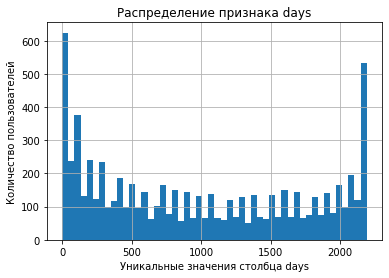

In [23]:
hists('days', 50)

Далее рассмотрим столбец `PaymentMethod`. По графику видно, что больше всего клиентов, которые пользуются электронным чеком, остлаьные варианты практически одинаковое распределение.

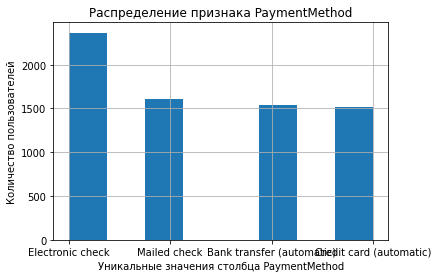

In [24]:
hists('PaymentMethod', 8)

Ниже рассмотрено распределение столбца `MonthlyCharges`. По графику видно, что довольно много клиентов, которые только пришли, как следствие ещё не вносили ежемесячный платёж. В остальном данные также не можем сказать, что распределены нормально. Довольно  много столбцов, которые могут говорить о различных тарифах внутри компании.

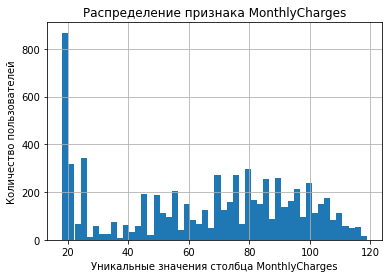

In [25]:
hists('MonthlyCharges', 50)   

Далее рассмотрим распределение по использованию электронных чеков. Большая часть клиентов использует электронные чеки. Их примерно на треть (~35%) больше, чем тех, кто не пользуется электроными чеками.

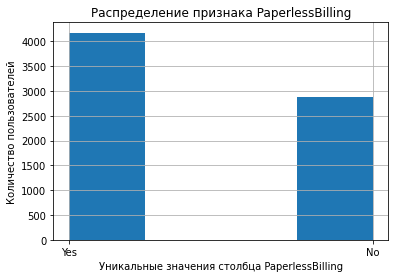

In [26]:
hists('PaperlessBilling', 4)

В данном столбце, также довольно много клиентов, которые не потратили денег на услуги компании. Что хорошо укладывается, что это новые клиенты. Однако "новеньких" клиентов примерно 600 человек, у кого не было или практически не было трат на ежемесячных услугах около 800, и соответственно, кто в целом ещё ничего не оплачивал в районе 1100 человек.

Возможно, у компании есть какой-то тестовый период, после котого клиенты уходят, таким образом можно было бы объяснить разницу между данными столбцами.


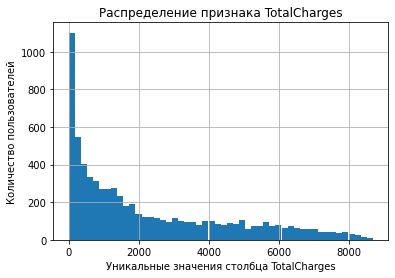

In [27]:
hists('TotalCharges', 50)

Услугами `OnlineSecurity` и `TechSupport` не пользуется примерно в 2,5 раза больше человек, чем тех, у кого она подключена. Возможно, данными услугами пользуются одни и те же клиенты.

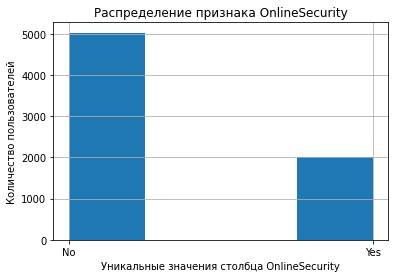

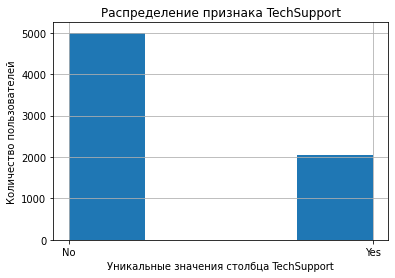

In [28]:
hists('OnlineSecurity', 4)
plt.show()
hists('TechSupport', 4)

Столбец `Dependents` содержит в себе информацию, есть ли у клиента дети, опекаемые люди и тд. Распределение примерно такое же, как в предыдущих столбцах, то есть клиентов, у которых нет иждевенцов примерно в 2,5 раза больше тех, у кого они есть.

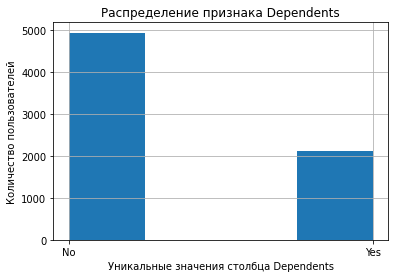

In [29]:
hists('Dependents', 4)

Большая часть клиентов имеют ежемесячную оплату, и примерно по поравну клиентов, у которых оплата ежегодная или даже раз в два года. Вторых немного больше даже.

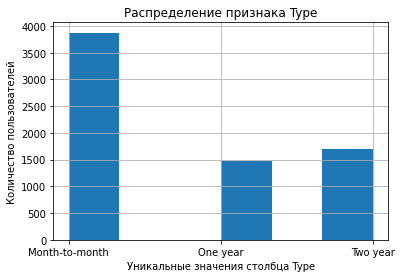

In [30]:
hists('Type', 6)    

В выборке примерно только 1/7 часть клиентов являются пенсионерами.

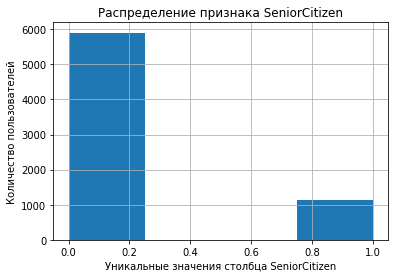

In [31]:
hists('SeniorCitizen', 4)

По наличию/отсутствию партнёра распределение равное у клиентов.

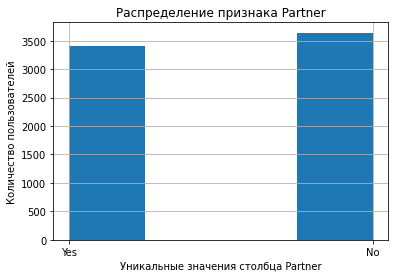

In [32]:
hists('Partner', 4) 

У большей части клиентов подключена услуга интернета, при этом примерно у 40% от всех клиентов подключено оптоволокно.

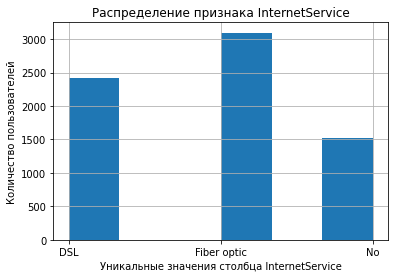

In [33]:
hists('InternetService', 6)

Услугами `OnlineBackup` и `DeviceProtection` пользуется около по 40% клиентов каждой.

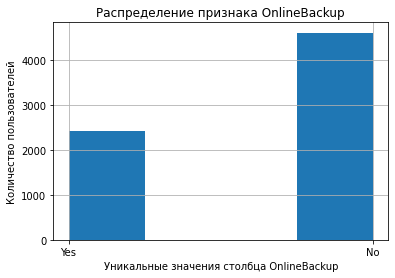

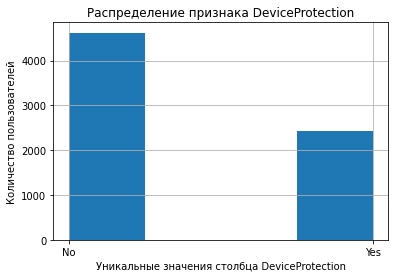

In [34]:
hists('OnlineBackup', 4)
plt.show()
hists('DeviceProtection', 4)

Стриминговым телевидением пользуется чуть больше клиентов, чем предыдущими услугами.

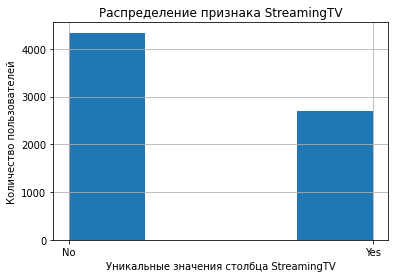

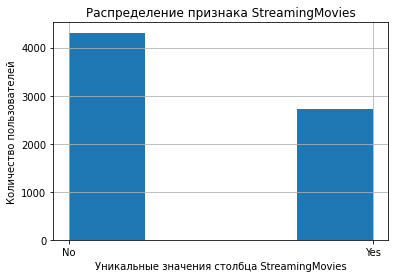

In [35]:
hists('StreamingTV', 4)
plt.show()
hists('StreamingMovies', 4)

Примерно у 3/7 клиентов подлючена услуга подключения к нескольким линиям одновременно.

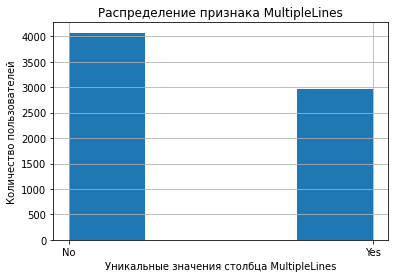

In [36]:
hists('MultipleLines', 4)

По полу распределение равное у клиентов.

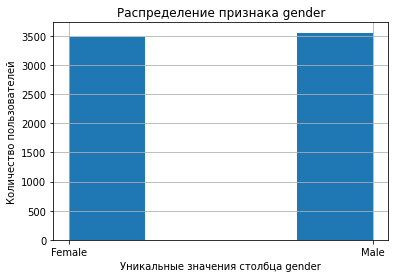

In [37]:
hists('gender', 4)

In [38]:
data = data.drop('gender', axis=1)

Так как не обнаружена корреляция со столбцом пола, а также по той причине, что нет значимых различий среди значений столбца, то данный столбец было принято решение удалить.

**Выводы по первому этапу:**
1) Были открыты и изучены данные 4 таблиц: `contract`, `personal`, `internet`, `phone`.

2) Были устранены пропуски

3) Была удалена часть ненужных столбцов, а также пара добавлена

4) Все данные были объеденены в единную переменную `data`


## Подготовка данных под модели

In [39]:
features = data.drop(['client_leave'], axis=1)
target = data['client_leave']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [40]:
get_data_info(features_train)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1699,One year,Yes,Mailed check,20.656250,958.000000,1279,0,No,No,No,No,No,No,No,No,No,No
2338,Two year,No,Bank transfer (automatic),19.953125,1323.000000,2191,0,Yes,Yes,No,No,No,No,No,No,No,No
4922,Month-to-month,No,Electronic check,59.812500,3642.000000,1857,0,Yes,Yes,DSL,Yes,Yes,No,No,No,No,Yes
101,Month-to-month,No,Electronic check,19.453125,19.453125,31,0,Yes,Yes,No,No,No,No,No,No,No,No
4687,Month-to-month,Yes,Credit card (automatic),94.687500,1915.000000,671,0,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 201 to 3886
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float16
 4   TotalCharges      5282 non-null   float16
 5   days              5282 non-null   int64  
 6   SeniorCitizen     5282 non-null   object 
 7   Partner           5282 non-null   object 
 8   Dependents        5282 non-null   object 
 9   InternetService   5282 non-null   object 
 10  OnlineSecurity    5282 non-null   object 
 11  OnlineBackup      5282 non-null   object 
 12  DeviceProtection  5282 non-null   object 
 13  TechSupport       5282 non-null   object 
 14  StreamingTV       5282 non-null   object 
 15  StreamingMovies   5282 non-null   object 
 16  MultipleLines     5282 non-null   object

None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,5282,5282,5282,5282.000000,5282.000,5282.000000,5282.0,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,3,2,4,NaN,NaN,NaN,2.0,2,2,3,2,2,2,2,2,2,2
top,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,0.0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,2941,3125,1751,NaN,NaN,NaN,4436.0,2750,3689,2309,3761,3450,3495,3767,3264,3249,3056
mean,NaN,NaN,NaN,inf,inf,982.055093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,30.046875,inf,750.297620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,18.250000,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,35.406250,385.125,245.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,70.312500,1387.000,853.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,89.734375,3759.000,1676.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
get_data_info(features_test)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3148,Month-to-month,No,Credit card (automatic),75.437500,3546.00,1432,0,No,No,Fiber optic,Yes,No,No,No,No,No,No
3093,One year,Yes,Credit card (automatic),54.406250,1517.00,853,0,No,Yes,DSL,No,Yes,No,Yes,No,No,No
4801,Two year,No,Bank transfer (automatic),80.875000,5824.00,2191,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,Yes
1944,Month-to-month,No,Mailed check,25.500000,215.25,242,0,No,Yes,DSL,No,No,No,No,No,No,No
3643,One year,No,Credit card (automatic),19.046875,990.50,1614,0,Yes,No,No,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 1318 to 5580
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1761 non-null   object 
 1   PaperlessBilling  1761 non-null   object 
 2   PaymentMethod     1761 non-null   object 
 3   MonthlyCharges    1761 non-null   float16
 4   TotalCharges      1761 non-null   float16
 5   days              1761 non-null   int64  
 6   SeniorCitizen     1761 non-null   object 
 7   Partner           1761 non-null   object 
 8   Dependents        1761 non-null   object 
 9   InternetService   1761 non-null   object 
 10  OnlineSecurity    1761 non-null   object 
 11  OnlineBackup      1761 non-null   object 
 12  DeviceProtection  1761 non-null   object 
 13  TechSupport       1761 non-null   object 
 14  StreamingTV       1761 non-null   object 
 15  StreamingMovies   1761 non-null   object 
 16  MultipleLines     1761 non-null   objec

None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,1761,1761,1761,1761.000000,1761.00,1761.000000,1761.0,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761
unique,3,2,4,NaN,NaN,NaN,2.0,2,2,3,2,2,2,2,2,2,2
top,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,0.0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,934,1046,614,NaN,NaN,NaN,1465.0,891,1244,787,1263,1164,1126,1232,1072,1062,1016
mean,NaN,NaN,NaN,inf,inf,997.817149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,30.234375,inf,739.486035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,18.406250,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,36.000000,422.25,304.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,70.375000,1426.00,914.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,90.562500,3906.00,1676.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
features = data.drop(['client_leave'], axis=1)
target = data['client_leave']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)
#категориальные признаки для OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

#категориальные признаки для OHE RandomForest
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf

['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [43]:
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'TotalCharges', 'days']

In [44]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [45]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ridge[ohe_features_ridge])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

# выводим результат
X_train_ridge.head()

,MonthlyCharges,TotalCharges,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
3792,0.881364,0.033137,-0.257657,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4005,-1.364625,-0.996877,-1.273501,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1766,-1.481598,-0.749344,-0.216222,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,-0.630931,-0.970129,-1.233401,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3419,0.910608,1.859590,1.494672,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [46]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
X_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ridge[ohe_features_ridge])

X_test_ridge = X_test_ridge.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)

# выводим результат
X_test_ridge.head()

,MonthlyCharges,TotalCharges,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
6199,0.824967,0.698589,0.434720,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3521,-0.382363,0.342855,1.006800,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5344,0.400939,1.436603,1.576207,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6795,0.676661,1.027775,0.925265,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3168,-1.521807,-0.550461,0.720760,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# получилось одинаковое количество признаков
X_train_ridge.shape, X_test_ridge.shape

((5282, 21), (1761, 21))

In [48]:
# получились одинаковые признаки в тренировочной и тестовой выборках
(X_train_ridge.columns != X_test_ridge.columns).sum()

0

## Обучение моделей
### Base model

In [49]:
%%time
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
result = roc_auc_score(target_test, dummy_clf.predict(features_test))
print("AUC-ROC базовой модели:", round(result, 2))

AUC-ROC базовой модели: 0.5
CPU times: user 3.22 ms, sys: 376 µs, total: 3.59 ms
Wall time: 12.3 ms


Базовая модель дала результат 0.5, что, конечно, ниже ТЗ (`auc-roc` > 0,85). Однако, теперь мы уверены, что задачу нельзя было решить более простой моделью. Поэтому перейдём к более сложным моделям.

### RidgeClassifier

In [50]:
%%time
model_ridge = RidgeClassifier(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0.1, 1, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='roc_auc', 
    n_jobs=-1)

gs_ridge.fit(X_train_ridge, y_train)

# лучшее значение roc_auc на кросс-валидации
print(f'best_score: {gs_ridge.best_score_ }')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score: 0.8421530735278836
best_params: {'alpha': 0.1}
CPU times: user 24.5 s, sys: 27.9 s, total: 52.4 s
Wall time: 52.4 s


Результат уже лучше базовой модели, однако, до ТЗ ещё немного не дотягивает (0,85). Поэтому для начала посмотрим на другие модели.

### Случайный лес

In [51]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [52]:
%%time
col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {'randomforestclassifier__n_estimators': range (10, 200),
                 'randomforestclassifier__max_depth': range (4, 20),
                 'randomforestclassifier__min_samples_leaf': range (1,8),
                 'randomforestclassifier__min_samples_split': range (2,10,2) }

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает намного быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8652203952733938
best_params: {'randomforestclassifier__n_estimators': 198, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 9}
CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


Отлично, результат выше ТЗ. Однако, рассмотрим ещё пару моделей, вдруг там окажется результат лучше.

### CatBoostClassifier

In [53]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

Потратив несколько часов времени на подсчёты в итоге сузила размах подбора гиперпараметров, чтобы обучение проходило за более быстрый срок. Поэтому модель ниже будет обучаться значительно быстрее.

In [54]:
%%time
cat_features = ohe_features_rf.copy()
model_cb = CatBoostClassifier(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cb = {
    'iterations': range(400, 600, 100),
    'learning_rate': np.arange(0.4, 0.5, 0.1),
    'depth': range(4, 6)
}


gs_cb = GridSearchCV(
    model_cb, 
    param_grid=param_grid_cb, 
    scoring='roc_auc', 
    n_jobs=-1)


gs_cb.fit(X_train_cb, y_train, cat_features=cat_features, verbose=100)

# лучшее значение roc_auc
print(f'best_score: {gs_cb.best_score_}')

# лучшие гиперпараметры
print(f'best_params: {gs_cb.best_params_}')


0:	learn: 0.5302563	total: 52.1ms	remaining: 20.8s
100:	learn: 0.2464817	total: 484ms	remaining: 1.43s
200:	learn: 0.1898072	total: 889ms	remaining: 880ms
300:	learn: 0.1533143	total: 1.29s	remaining: 425ms
399:	learn: 0.1275288	total: 1.74s	remaining: 0us
0:	learn: 0.5306972	total: 4.88ms	remaining: 1.95s
100:	learn: 0.2372705	total: 441ms	remaining: 1.3s
200:	learn: 0.1806583	total: 850ms	remaining: 841ms
300:	learn: 0.1432878	total: 1.31s	remaining: 430ms
399:	learn: 0.1198734	total: 1.73s	remaining: 0us
0:	learn: 0.5401908	total: 4.65ms	remaining: 1.85s
100:	learn: 0.2432490	total: 406ms	remaining: 1.2s
200:	learn: 0.1871335	total: 826ms	remaining: 818ms
300:	learn: 0.1496668	total: 1.24s	remaining: 406ms
399:	learn: 0.1231329	total: 1.67s	remaining: 0us
0:	learn: 0.5344166	total: 4.48ms	remaining: 1.79s
100:	learn: 0.2318746	total: 431ms	remaining: 1.27s
200:	learn: 0.1773914	total: 860ms	remaining: 852ms
300:	learn: 0.1414266	total: 1.33s	remaining: 439ms
399:	learn: 0.1191844	to

In [55]:
# сохранение параметров лучшей модели
model_best = CatBoostClassifier(random_state=RANDOM_STATE,
                               cat_features=cat_features,
                               iterations=400,
                               depth = 4,
                               learning_rate=0.4)
model_best.fit(X_train_cb, y_train, verbose=500)

0:	learn: 0.5376626	total: 6.19ms	remaining: 2.47s
399:	learn: 0.1316832	total: 2.02s	remaining: 0us


Отлично, результат выше ТЗ достигнут и у `CatBoost` результат оказался немного выше `RandomForest`. Поэтому лучшей моделью становится `CatBoost`. Перейдём к её тестированию  на тестовых данных.

## Тестирование лучшей модели

In [56]:
cb_prediction = gs_cb.predict_proba(X_test_cb)[:, 1]
res_best_model = roc_auc_score(y_test, cb_prediction)
print('AUC-ROC лучшей модели:', res_best_model)

AUC-ROC лучшей модели: 0.9106598154970356


Отлично, результат на тестовых данных также оказался выше ТЗ (0,85 и выше). Проверим также лучшую модель на метрику `acuracy`.

In [57]:
print('Точность лучшей модели:', accuracy_score(y_test, gs_cb.predict(X_test_cb)).round(3))

Точность лучшей модели: 0.865


Другими словами получаем, что модель предсказывает верно в 86 случая из 100. Ниже представлен график `ROC-кривой`.

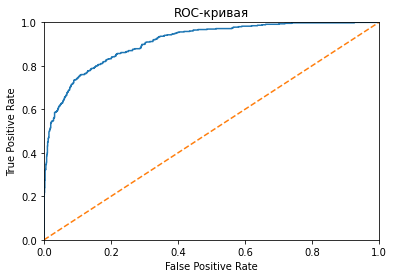

In [58]:
# график ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, cb_prediction)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

А также рассмотрим какие признаки оказались важны для обучения нашей модели.

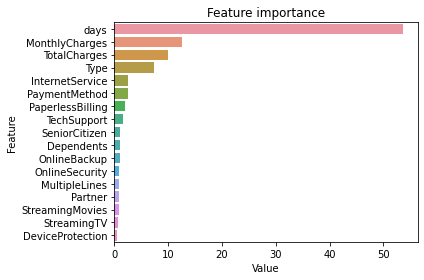

In [59]:
# построение графика, какие фичи оказались наиболее важными для модели
def feature_import_barplot(model_best):
    feature_importance = model_best.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature importance')
    plt.tight_layout()
    plt.show();
    
feature_import_barplot(model_best)    

Получается, что самый важный признак при обучении модели оказался - количество дней, которые абонент провёл в компании. На втором месте и с большим разрывом - ежемесечная оплата абонентом. И замыкает тройку - общее количество потраченных денег абонентом. 

Матрица ошибок представлена ниже.

In [82]:
confusion_matrix(y_test, model_best.predict(X_test_cb))

array([[1217,   90],
       [ 147,  307]])

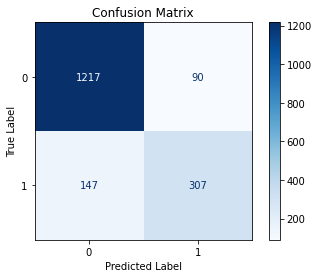

In [81]:
# матрица ошибок

color = 'black'
matrix = plot_confusion_matrix(model_best, X_test_cb, y_test, cmap=plt.cm.Blues)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.title('')
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.title('Confusion Matrix')
plt.show()

## Выводы

Данный проект выполнялся для оператора связи «Ниединогоразрыва.ком», которые хотят научиться прогнозировать отток клиентов. Прогнозирование необходимо, чтобы в случае, если пользователь планирует уйти, то ему будут предложены промоокды и специальные условия. Для обучения модели машинного обучения были подготовлены персональные данные о некоторых клиентах, информация их тарифах и договорах.

**Цель проекта:**
Построить модель, которая будет предсказывать планирует ли клиент уходить. При этом метриика `auc-roc` должна быть выше 0,85.

Более подробно информация об основных типах услуг была рассмотрена при описании данных. Информация о договорах актуальна на 1 февраля 2020.

Проект содержит в себе несколько этапов, поэтому рассмотрим более подробно каждый из них.

**1. Исследовательский анализ данных**
В ходе первого этапа, были рассмотрены данные, которые состояли из четырёх источников.

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Было выяснено, что всего были получены данные 7043 клиентов, а меньшее количество значений в столбцах `internet.csv` и `phone.csv` было по причине того, что не все клиенты пользовались услугами интернета или телефонии.

Был создан новый столбец `days` - это количество дней проведённых клиентами в компании для ушедших клиентов, либо на день сбора данных, которые продолжают пользоваться услугами связи оператора.

Четыре файла были объедены в один для более удобной работы с данными, после чего были была проведена работа над изменением типов данных, устранением пропусков и другой подготовкой данный для предстоящего обучения.

*Также в рамках данного блока*, был проведён корреляционный анализ, где самая высокая корреляция была целевого признака с количеством дней клиента в компании (0,47). Рассмотрев более подробно каждый из признаков было принято решение удалить признак `gender`, в силу того, что он не коррелировал с целевым признаком, и среди данных поравну количество клиентов мужского и женского полов.

**2. Подготовка данных под модели**

На втором этапе, было деление данных на две группы: обучение и тестирование. Также для более качественного обучение части моделей данные были закодированы и приведены к одинаковому масштабу.

**3. Обучение моделей**

Для выполнения цели было выбрано несколько моделей: `DummyClassifier`, `RidgeClassifier`, `RandomForestClassifier`, `CatBoostClassifier`.

Базовая модель (в нашем случае `DummyClassifier`) использовалась для проверки, может ли более простая модель решить поставленную задачу. Однако, её результат в 0,5 нас не удовлетворил, поэтому были рассмотрены уже модели машинного обучения.

Модели на тестовых данных `RandomForestClassifier` и `CatBoostClassifier` смогли показать результаты выше ТЗ (`AUC-ROC>0.85`), однако результат у `CatBoostClassifier` оказался выше, поэтому только на ней проводили тестирование.

Обучение моделей и прочее описание более подробно изложено в данном блоке проекта.

**4. Тестирование лучшей модели**

Ниже представлены результаты лучшей модели `CatBoostClassifier` на тестовых данных. Использовалось две метрики: `AUC-ROC` и `accuracy`.


In [60]:
print('AUC-ROC лучшей модели:', res_best_model.round(3))
print('Точность лучшей модели:', accuracy_score(y_test, gs_cb.predict(X_test_cb)).round(3))

AUC-ROC лучшей модели: 0.911
Точность лучшей модели: 0.865


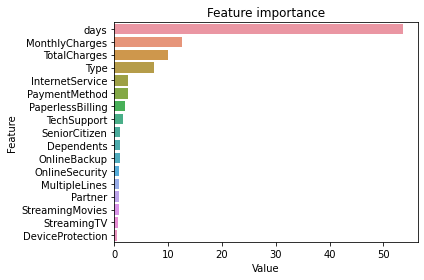

На графике выше представлено распределение значимости каждых признаков данных. Самым важным признаком для модели оказалось количество дней, проведённых клиентом в компании, далее количество потраченных средств за месяц и после общее количество трат. Подобные результаты мы уже видели при проведении корреляционного анализа.

А на графике ниже представлена матрица ошибок лучшей модели.

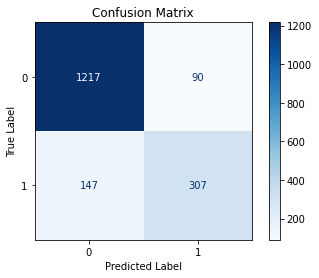

А также график AUC-ROC
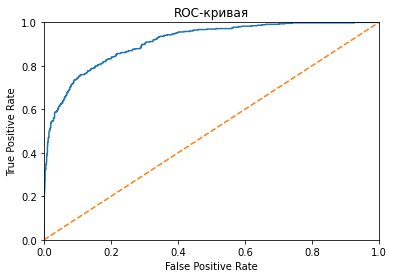